In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pydataset import data

from scipy import stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

import env
import util
import wrangle
import split_scale
import explore
import evaluate

# Evaluate Notes and Practice

In [2]:
df = data('tips')

In [3]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


## Split df into train and test

In [4]:
train, test = split_scale.split_my_data(df)

In [5]:
print(train.head(1), train.shape)

     total_bill   tip   sex smoker   day   time  size
149        9.78  1.73  Male     No  Thur  Lunch     2 (170, 7)


In [6]:
print(test.head(1), test.shape)

     total_bill  tip   sex smoker  day    time  size
113       38.07  4.0  Male     No  Sun  Dinner     3 (74, 7)


In [7]:
X_train = train['total_bill']
X_test = test['total_bill']
y_train = train['tip']
y_test = test['tip']

## fit and predict on the single-variate ols model

In [8]:
ols_model = ols('tip ~ total_bill', data=train).fit()

In [9]:
ols_yhat = ols_model.predict(X_train) 
ols_yhat.head()

149    2.038397
214    2.358964
179    2.021863
42     2.743828
120    3.351895
dtype: float64

## Create and validate a plot_residuals(x, y, df) function

In [10]:
def plot_residuals(x, y, df):
    """
    Takes: 
           x, feature string
           y, target string
           df
    Returns: 
           plot of the residuals from linear regression
           of y on x
    """
    sns.residplot(x, y, df)
    plt.title('Residuals')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

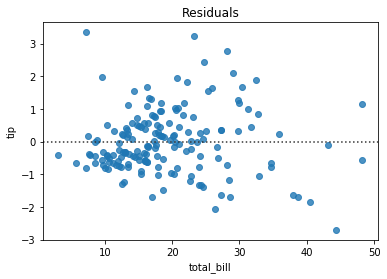

In [11]:
plot_residuals('total_bill', 'tip', train)

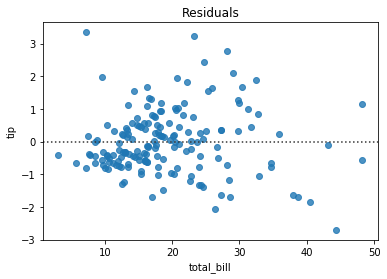

In [12]:
# call function from evaluate.py module

evaluate.plot_residuals('total_bill', 'tip', train)

## Create a regression_errors(y, yhat) function

- returns the SSE, ESS, TSS, MSE and RMSE metrics

In [13]:
def regression_errors(y, yhat):
    """
    Takes: 
          target variable y, Pandas Series
          yhat, calculated regression Pandas Series
    Returns:
          SSE, ESS, TSS, MSE, RMSE
    """
    from math import sqrt
    SSE = ((yhat - y) ** 2).sum()
    MSE = SSE / len(y)
    ESS = sum((yhat - y.mean())**2)
    TSS = SSE + ESS
    RMSE = sqrt(MSE)
    print(f'SSE: {round(SSE, 3)}')
    print(f'ESS: {round(ESS, 3)}')
    print(f'TSS: {round(TSS, 3)}')
    print(f'MSE: {round(MSE, 3)}')
    print(f'RMSE: {round(RMSE,3)}')
    return SSE, ESS, TSS, MSE, RMSE

In [14]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y_train, ols_yhat)

SSE: 163.505
ESS: 97.261
TSS: 260.765
MSE: 0.962
RMSE: 0.981


In [15]:
# Call function from evaluate.py

SSE, ESS, TSS, MSE, RMSE = evaluate.regression_errors(y_train, ols_yhat)

SSE: 163.505
ESS: 97.261
TSS: 260.765
MSE: 0.962
RMSE: 0.981


### Looks good!

## Create a baseline_mean_errors(y)

In [16]:
def baseline_mean_errors(y):
    """
    Takes: 
          target variable y, Pandas Series
    Returns:
          SSE, MSE, RMSE for baseline values
    """
    bSSE = ((y.mean() - y) ** 2).sum()
    bMSE = bSSE / len(y)
    bRMSE = bMSE ** .5
    print(f'baseline SSE: {round(bSSE, 3)}')
    print(f'baseline MSE: {round(bMSE, 3)}')
    print(f'baseline RMSE: {round(bRMSE,3)}')
    return bSSE, bMSE, bRMSE

In [17]:
bSSE, bMSE, bRMSE = baseline_mean_errors(y_train)

baseline SSE: 260.765
baseline MSE: 1.534
baseline RMSE: 1.239


In [18]:
# Validate function from evaluate.py

bSSE, bMSE, bRMSE = evaluate.baseline_mean_errors(y_train)

baseline SSE: 260.765
baseline MSE: 1.534
baseline RMSE: 1.239


### We can see from the RMSE of .98 using 

## Create a function better_than_baseline(y, yhat)

- Takes in the y (target variable) and yhat (predictions) and returns True if the model performs better than the baseline.

In [19]:
def better_than_baseline(y, yhat):
    """
    Takes: 
          y variable, Pandas Series
          yhat variable, Pandas Series
    Returns:
          boolean value evaluating statement
              - model performs better
              than baseline
    """
    SSE = ((yhat - y) ** 2).sum()
    bSSE = ((y.mean() - y) ** 2).sum()
    return SSE < bSSE

In [20]:
better_than_baseline(y_train, ols_yhat)

True

In [21]:
# Validate that the function works from the evaluate.py file

evaluate.better_than_baseline(y_train, ols_yhat)

True

## Create a function model_significance(ols_model)

- takes the ols model as input and returns the amount of variance explained in your model, and the value telling you whether the correlation between the model and the tip value are statistically significant.

In [22]:
def model_significance(ols_model):
    """Takes:
             ols model
       Returns:
             r2
             p_value
    """
    p_value = ols_model.f_pvalue
    r2 = ols_model.rsquared
    print(f'The independent variable explains {r2:.2%} of the variance in our dependent variable.')
    print(f'Our p_value is {round(p_value,4)}')
    return r2, p_value

In [23]:
r2, p = model_significance(ols_model)

The independent variable explains 37.30% of the variance in our dependent variable.
Our p_value is 0.0


In [24]:
# Validate the model_significance function works from evaulate.py

r2, p = evaluate.model_significance(ols_model)

The independent variable explains 37.30% of the variance in our dependent variable.
Our p_value is 0.0


# Evaluate the single-variate ols model

- Compute evaluation metrics for the model


- Compute a baseline yhat using just the mean of our target variable, tip


- Check our p-value and f statistic

In [25]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     99.93
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           9.34e-19
Time:                        22:42:52   Log-Likelihood:                -237.91
No. Observations:                 170   AIC:                             479.8
Df Residuals:                     168   BIC:                             486.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1401      0.191      5.959      0.000       0.762       1.518
total_bill     0.0919      0.009      9.997      0.000       0.074       0.110
==============================================================================
Omnibus:                       14.604   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.203
Skew:                           0.602   Prob(JB):                     0.000184
Kurtosis:                       3.990   Cond. No.                         52.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
eval_ols_df = pd.DataFrame({'x': X_train, 'y': y_train, 'yhat': ols_yhat })
eval_ols_df.head()

,x,y,yhat
149,9.78,1.73,2.038397
214,13.27,2.50,2.358964
179,9.60,4.00,2.021863
42,17.46,2.54,2.743828
120,24.08,2.92,3.351895


In [27]:
eval_ols_df['residual'] = eval_ols_df.yhat - eval_ols_df.y

In [28]:
eval_ols_df.head()

,x,y,yhat,residual
149,9.78,1.73,2.038397,0.308397
214,13.27,2.50,2.358964,-0.141036
179,9.60,4.00,2.021863,-1.978137
42,17.46,2.54,2.743828,0.203828
120,24.08,2.92,3.351895,0.431895


# Baseline evaluation using the mean of tip

- Create a column called baseline that is the repeated mean value of total_bill.


- Compare evaluation metrics of the first ols model with this baseline model.

In [29]:
eval_ols_df = eval_ols_df.assign(baseline=eval_ols_df.y.mean())
eval_ols_df.head()

,x,y,yhat,residual,baseline
149,9.78,1.73,2.038397,0.308397,2.896882
214,13.27,2.50,2.358964,-0.141036,2.896882
179,9.60,4.00,2.021863,-1.978137,2.896882
42,17.46,2.54,2.743828,0.203828,2.896882
120,24.08,2.92,3.351895,0.431895,2.896882


In [30]:
eval_ols_df['baseline_residual'] = eval_ols_df.baseline - eval_ols_df.y

In [31]:
eval_ols_df.head()

,x,y,yhat,residual,baseline,baseline_residual
149,9.78,1.73,2.038397,0.308397,2.896882,1.166882
214,13.27,2.50,2.358964,-0.141036,2.896882,0.396882
179,9.60,4.00,2.021863,-1.978137,2.896882,-1.103118
42,17.46,2.54,2.743828,0.203828,2.896882,0.356882
120,24.08,2.92,3.351895,0.431895,2.896882,-0.023118
